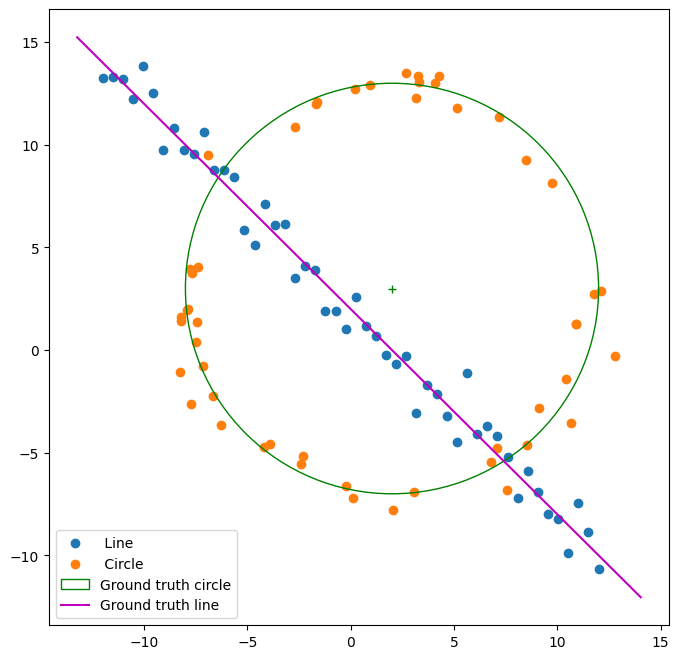

In [2]:
# Generation o f a Noisy Po in t Set Conforming t o a Line and a C i r c l e
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib
# np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1 , 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # A l l p o in t s
fig , ax = plt . subplots ( 1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line ' )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= ' Circle ' )
circle_gt = plt . Circle (( x0_gt , y0_gt ) , r , color= 'g', fill =False , label= 'Ground truth circle')
ax . add_patch ( circle_gt )
ax . plot ( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm', label= 'Ground truth line' )
plt . legend ()

Samples [68  2]
[7.8 1.2] [22.61437835  9.53470872]
m, b: 1.9817681251821206 7.156586970474949
[9.32557241e+00 5.61018144e+01 2.04866948e+02 1.11058636e+02
 2.84768709e+00 4.36456342e+01 5.09706007e+01 2.00131977e+02
 7.57660863e+01 5.01560988e+01 2.68142134e+02 4.53159755e+01
 9.18378133e+01 8.60630549e+00 5.56678331e+00 7.33085389e+01
 1.10743284e+02 5.36669834e+01 9.53849979e+01 4.05112019e+01
 2.72783840e+01 2.55796868e+02 1.92575025e+02 2.31324407e+02
 8.92905022e+01 4.03227111e+01 1.46155603e+02 1.26050883e+02
 1.59624368e+02 4.13982598e+01 7.33616606e+01 7.24435583e+01
 6.26205084e-01 6.12659910e+01 1.66121882e+01 2.65464316e+01
 1.30349923e+01 1.20939687e+02 9.96575983e+01 2.47857621e+02
 6.81707273e+01 3.12037330e+01 2.00845451e+01 2.69400573e+01
 1.81921426e+02 1.71337363e+01 8.32852437e+00 8.98198352e+01
 1.06238970e+02 1.86278231e+02 1.94595257e+02 2.26593153e+02
 2.18991981e+01 1.98271762e+02 1.24382824e+01 1.74376933e+02
 4.53631192e+02 6.78873750e+01 2.63007867e-01 3.957

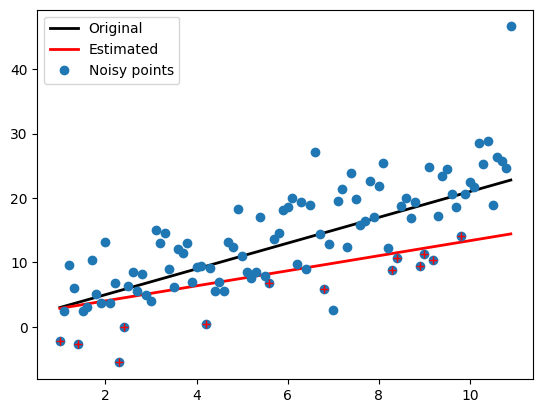

In [3]:
# RANSAC

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2
c = 1
xo = np.arange(1,11, 0.1) # Un-corrupted x
mu, sigma = 0, 5 # mean and standard deviation
#x = xo + np.random.normal(mu, sigma, len(xo)) # noisy x
x = xo
n = np.random.normal(mu, sigma, len(xo))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

def line(x,y):
    m = (y[1] - y[0])/(x[1] - x[0])
    b = y[0] - m*x[0]
    print("m, b:", m, b)
    return m, -1, b

def distance(parameters, x, y):
    a = parameters[0]
    b = parameters[1]
    d = parameters[2]
    return (a*x + b*y - d)**2


thresh = 10
s = 2
loop = True 
consensus = []
while loop:
    samples = np.random.choice(len(x), 2, replace=False)
    print("Samples", samples)
    xs = x[samples]
    ys = y[samples]
    print(xs,ys)
    parameters = line(xs,ys)
    print(distance(parameters, x, y) )
    consensus =  distance(parameters, x, y) < thresh
    print('Consensus: ', consensus)
    print("Lenght:", sum(consensus))
    if sum(consensus) >= 2:
        loop = False
    

xc = x[consensus]
yc = y[consensus]
print("xc:", xc)
print("yc", yc)
X = np.concatenate([xc.reshape(len(xc),1), np.ones((len(xc), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@yc
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.plot(xc, yc, '+', color='r')
plt.legend(loc='best')

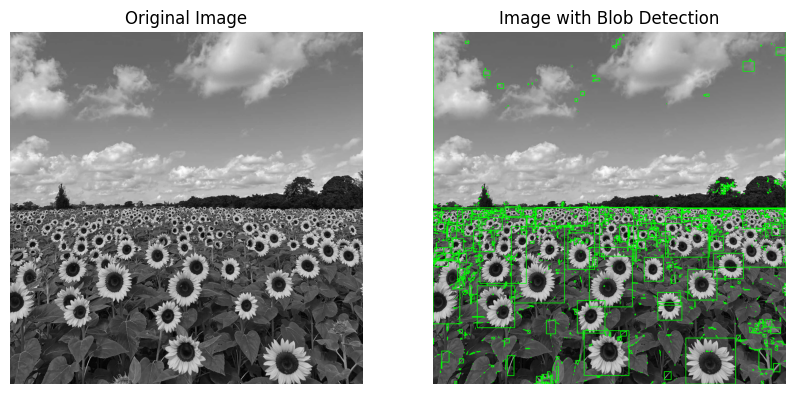

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image (grayscale)
image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    print("Error: Could not load the image.")
else:
    # Apply thresholding to create a binary image
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Find connected components (blobs) in the binary image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Create a copy of the original image to draw on
    image_with_blobs = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Iterate through the detected blobs
    for label in range(1, num_labels):  # Skip background label (label 0)
        # Get blob properties
        left, top, width, height, area = stats[label]

        # Draw bounding box around the blob on the image copy
        cv2.rectangle(image_with_blobs, (left, top), (left + width, top + height), (0, 255, 0), 2)

    # Display both the original image and the image with blob detection
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(image, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(122), plt.imshow(cv2.cvtColor(image_with_blobs, cv2.COLOR_BGR2RGB))
    plt.title('Image with Blob Detection'), plt.axis('off')
    plt.show()

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define the range of σ (sigma) values for scale-space
sigma_values = np.arange(1, 10, 0.5)  # You can adjust the range and step size

# Initialize a list to store detected circles
detected_circles = []

# Perform scale-space extrema detection
for sigma in sigma_values:
    # Apply the LoG filter to the grayscale image
    blurred = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    log_image = cv2.Laplacian(blurred, cv2.CV_64F)
    
    # Find local extrema in the LoG image
    extrema = cv2.dilate(log_image, None)
    extrema = (extrema == log_image).astype(np.uint8)
    
    # Find circle centers from extrema
    centers = np.column_stack(np.where(extrema))
    
    # Append detected centers with current σ value to the list
    detected_circles.extend([(x, y, sigma) for x, y in centers])

# Filter and select the largest circles based on some criteria (e.g., radius)
# You may use techniques like non-maximum suppression to select the most prominent circles.

# Sort circles by radius (largest first)
detected_circles.sort(key=lambda x: x[2], reverse=True)

# Get parameters of the largest circle
largest_circle = detected_circles[0]
x, y, largest_sigma = largest_circle
radius = int(2 * largest_sigma)  # Adjust this factor as needed

# Create a copy of the original image to draw on
image_with_circle = image.copy()

# Draw the largest circle on the copy of the image
cv2.circle(image_with_circle, (x, y), radius, (0, 255, 0), 2)

# Display the original image and the image with the largest circle overlaid on the same graph
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
plt.title('Image with Largest Circle')
plt.axis('off')

plt.show()

# Report parameters of the largest circle
print("Parameters of the largest circle:")
print("Center (x, y):", x, y)
print("Radius:", radius)
print("Sigma (σ) used:", largest_sigma)

IndentationError: expected an indented block after 'for' statement on line 19 (1131432606.py, line 20)